In [1]:
import numpy as np
import FuncParcel
from scipy import stats
import matplotlib.pyplot as plt
import nibabel as nib
import matplotlib as mpl
from matplotlib import colors
import pickle
from collections import Counter
%matplotlib inline
from sklearn.metrics import mutual_info_score as NMI
from sklearn.metrics import adjusted_rand_score as RAND

# Network Based Parcellation

In [2]:
#path to files ncessary for parcellation
MGHadjmat = np.loadtxt('/home/despoB/connectome-thalamus/Thalamic_parcel/MGH_Gordon_ConsesnsusCI_thalamocortical_pcorr_avemat')
NKIadjmat = np.loadtxt('/home/despoB/connectome-thalamus/Thalamic_parcel/NKI_645_Gordon_ConsesnsusCI_thalamocortical_pcorr_avemat')


# load subcortical voxel info
Thalamus_voxel_coordinate = np.loadtxt('/home/despoB/connectome-thalamus/ROIs/thalamus_voxels_ijk_indices', dtype = int)

subcorticalcortical_ROIs = np.loadtxt('/home/despoB/connectome-thalamus/ROIs/Cortical_CI_plus_thalamus_ROIs')
subcortical_voxels = np.loadtxt('/home/despoB/connectome-thalamus/ROIs/thalamus_voxel_indices')
cortical_ROIs =np.loadtxt('/home/despoB/connectome-thalamus/ROIs/Gordon_Network_consensusCI')
Cortical_CI = np.loadtxt('/home/despoB/connectome-thalamus/ROIs/Gordon_Network_consensusCI')


#call function
_, MGH_ParcelCIs, _, = FuncParcel.parcel_subcortical_network(MGHadjmat, subcorticalcortical_ROIs, \
            subcortical_voxels, cortical_ROIs, Cortical_CI)
_, NKI_ParcelCIs, _, = FuncParcel.parcel_subcortical_network(NKIadjmat, subcorticalcortical_ROIs, \
            subcortical_voxels, cortical_ROIs, Cortical_CI)

In [20]:
#create a mask based on the morel atlas 
Morel_atlas = np.loadtxt('/home/despoB/connectome-thalamus/Thalamic_parcel/Morel_parcel')
Morel_mask = np.loadtxt('/home/despoB/connectome-thalamus/Thalamic_parcel/morel_mask')
mask_value = Morel_mask==0


## Display thalamic parcellation over MNI template

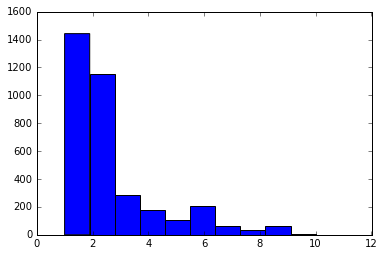

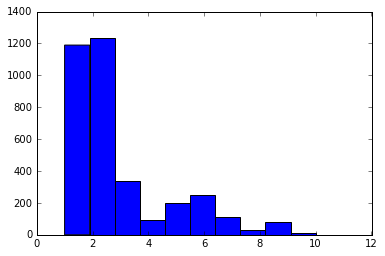

NMI = 0.638317078276
RAND = 0.472090609335


In [21]:
# sort CI vector
def sort_CI(Thalamo_ParcelCIs):
    CIs = np.zeros(len(Thalamus_voxel_coordinate))
    for i, thalamus_voxel_index in enumerate(Thalamus_voxel_coordinate[:,3]):
        CIs[i] = Thalamo_ParcelCIs[thalamus_voxel_index][0]
    CIs = CIs.astype(int)
    return CIs
                        

NKI_CIs = sort_CI(NKI_ParcelCIs)
MGH_CIs = sort_CI(MGH_ParcelCIs)

plt.hist(NKI_CIs, bins=np.max(np.unique(NKI_CIs)))
plt.show()
plt.hist(MGH_CIs, bins=np.max(np.unique(MGH_CIs)))
plt.show()
print 'NMI =', NMI(NKI_CIs, MGH_CIs)
print 'RAND =', RAND(NKI_CIs, MGH_CIs)

np.savetxt('/home/despoB/connectome-thalamus/Thalamic_parcel/MGH_Thalamus_WTA_CIs', MGH_CIs, )
np.savetxt('/home/despoB/connectome-thalamus/Thalamic_parcel/NKI_Thalamus_WTA_CIs', NKI_CIs, )
#FuncParcel.save_object(MGH_CIs, '/home/despoB/kaihwang/bin/FuncParcel/Data/MGH_Thalamus_CIs')

In [24]:
def visualize_parcellation(CIs, cmap, savepath):
    # show volum image
    MNI_img = nib.load('/home/despoB/connectome-thalamus/ROIs/MNI152_T1_2mm_brain.nii.gz')
    MNI_data = MNI_img.get_data()

    # create mask for parcel
    Mask = np.zeros(MNI_data.shape)


    # assign CI to each subcortical voxel
    for i, CI in enumerate(CIs):
        Mask[Thalamus_voxel_coordinate[i,0], Thalamus_voxel_coordinate[i,1], Thalamus_voxel_coordinate[i,2]] = CIs[i].astype(int)
    Mask = np.ma.masked_where(Mask == 0, Mask)

    # flip dimension to show anteiror of the brain at top
    MNI_data = MNI_data.swapaxes(0,1)
    Mask = Mask.swapaxes(0,1)

    # some plot setting (colormap), interplotation..
    #cmap = colors.ListedColormap(['red', 'blue', 'cyan', 'yellow', 'teal', 'purple', 'pink', 'green', 'black'])
    #cmap = colors.ListedColormap(['blue', 'red', 'cyan', 'yellow', 'green'])
    # display slice by slice
    Z_slices = range(np.min(Thalamus_voxel_coordinate[:,2])+2, np.max(Thalamus_voxel_coordinate[:,2])-1,2)
    fig = plt.figure()
    for i, Z_slice in enumerate(Z_slices):
        #if i <4:
        a = plt.subplot(1, len(Z_slices), i+1 )
        #else:
        #    a = plt.subplot(2, len(Z_slices)/2, i+1-4 )
        a.set_yticks([])
        a.set_xticks([])
        plt.imshow(MNI_data[45:65, 30:60, Z_slice], cmap='gray', interpolation='nearest')
        plt.imshow(Mask[45:65, 30:60, Z_slice],cmap=cmap, interpolation='none', vmin = 1, vmax=len(np.unique(CIs)))
        plt.ylim(plt.ylim()[::-1])
        
    fig.tight_layout() 
    fig.set_size_inches(6.45, 0.7) 
    
    plt.savefig(savepath, bbox_inches='tight')

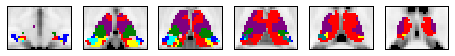

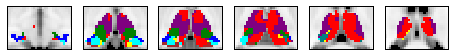

In [25]:
cmap = colors.ListedColormap(['red', 'purple', 'green', 'yellow', 'cyan', 'blue', 'brown', 'pink', 'teal', 'pink'])
NKI_CIs[mask_value]=0
MGH_CIs[mask_value]=0
visualize_parcellation(NKI_CIs, cmap, 'Data/MGH_CI_WTA_Tha_Parcel.png')
visualize_parcellation(MGH_CIs, cmap, 'Data/NKI_CI_WTA_Tha_Parcel.png')

# Visualize Morel anatomcial Parcellation

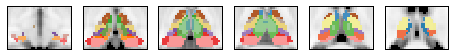

In [26]:
cmap = 'Paired'
Morel_atlas = np.loadtxt('/home/despoB/connectome-thalamus/Thalamic_parcel/Morel_parcel')
#order = Morel_atlas.argsort()
#morel_ranks = order.argsort()

visualize_parcellation(Morel_atlas, cmap, 'Data/Morel_Parcel.png')

# Parcellation with the FSL atlas


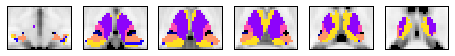

In [29]:
cmap = 'gnuplot2'
FSL_ana = np.loadtxt('/home/despoB/connectome-thalamus/Thalamic_parcel/fsl_thalamus_ana_parcel')
FSL_ana[mask_value]=0
visualize_parcellation(FSL_ana, cmap, 'Data/FSL_ana_Parcel.png')

# Visualize nodal properties (PC, WMDs... etc)

In [38]:
def visualize_nodal_property(CIs, lb, ub, savepath):
    # show volum image
    MNI_img = nib.load('/home/despoB/connectome-thalamus/ROIs/MNI152_T1_2mm_brain.nii.gz')
    MNI_data = MNI_img.get_data()

    # create mask for parcel
    Mask = np.zeros(MNI_data.shape)


    # assign CI to each subcortical voxel
    for i, CI in enumerate(CIs):
        Mask[Thalamus_voxel_coordinate[i,0], Thalamus_voxel_coordinate[i,1], Thalamus_voxel_coordinate[i,2]] = CIs[i]
    Mask = np.ma.masked_where(Mask == 0, Mask)

    # flip dimension to show anteiror of the brain at top
    MNI_data = MNI_data.swapaxes(0,1)
    Mask = Mask.swapaxes(0,1)

    # some plot setting (colormap), interplotation..
    #cmap = colors.ListedColormap(['red', 'blue', 'cyan', 'yellow', 'teal', 'purple', 'pink', 'green', 'black'])
    #cmap = colors.ListedColormap(['blue', 'red', 'cyan', 'yellow', 'green'])
    cmap = plt.get_cmap('spring')
    # display slice by slice
    Z_slices = range(np.min(Thalamus_voxel_coordinate[:,2])+2, np.max(Thalamus_voxel_coordinate[:,2])-1,2)
    fig = plt.figure()
    for i, Z_slice in enumerate(Z_slices):
        a = plt.subplot(2, len(Z_slices)/2, i+1 )
        a.set_yticks([])
        a.set_xticks([])
        plt.imshow(MNI_data[45:65, 30:60, Z_slice], cmap='gray', interpolation='nearest')
        im=plt.imshow(Mask[45:65, 30:60, Z_slice],cmap=cmap, interpolation='none', vmin =lb, vmax=ub)
        plt.ylim(plt.ylim()[::-1])

    cbar_ax = fig.add_axes([0.92,.25,.025,.52])
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=[lb, ub])
    cbar.ax.tick_params(labelsize=12)
    fig.set_size_inches(4.5,2.5)
    plt.savefig(savepath, bbox_inches='tight')

In [34]:
# load subcortical voxel info
Thalamus_voxel_coordinate = np.loadtxt('/home/despoB/connectome-thalamus/ROIs/thalamus_voxels_ijk_indices', dtype = int)
#load data
Tha_PCs = pickle.load(open('/home/despoB/kaihwang/bin/FuncParcel/Data/MGH_Tha_PCs', "rb"))
Tha_WMD = pickle.load(open('/home/despoB/kaihwang/bin/FuncParcel/Data/MGH_Tha_WMDs', "rb"))
#visualize_nodal_property(Tha_NNC[320:]/15, 0, 9)

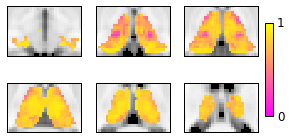

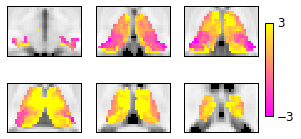

In [56]:
AvePC = pickle.load(open("/home/despoB/connectome-thalamus/Graph/MGH_avemat_tha_nodal_pcorr_PCs"))
PCs = AvePC[333:]/100
PCs[mask_value]=0
visualize_nodal_property(PCs, 0, 1, 'Data/MGH_Gordon_PC.png')
AveWMD = pickle.load(open("/home/despoB/connectome-thalamus/Graph/MGH_avemat_tha_nodal_pcorr_WMDs"))
WMD = AveWMD[333:]/100
WMD[mask_value]=np.nan
visualize_nodal_property(WMD, -3, 3, 'Data/MGH_Gordon_WMD.png')

##thalamocortical PC

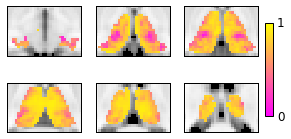

In [39]:
PCs = Tha_PCs[320:]/13.5
PCs[mask_value]=0
visualize_nodal_property(PCs, 0, 1, 'Data/Tha_PC.png')

## thalamocortical WMD

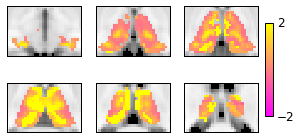

In [40]:
WMDs=Tha_WMD[320:]/15
WMDs[mask_value]=np.nan
visualize_nodal_property(WMDs, -2, 2, 'Data/Tha_WMD.png')

# Visualize lesion maps

In [105]:
def visualize_lesions(fn, savepath):
    # show volum image
    MNI_img = nib.load(fn)
    MNI_data = MNI_img.get_data()

    # create mask for parcel
    #Mask = np.zeros(MNI_data.shape)

    # flip dimension to show anteiror of the brain at top
    MNI_data = MNI_data.swapaxes(0,1)

    Z_slices = range(np.min(Thalamus_voxel_coordinate[:,2])+2, np.max(Thalamus_voxel_coordinate[:,2])-1,2)
    fig = plt.figure()
    for i, Z_slice in enumerate(Z_slices):
        #if i <4:
        a = plt.subplot(1, len(Z_slices), i+1 )
        #else:
        #    a = plt.subplot(2, len(Z_slices)/2, i+1-4 )
        a.set_yticks([])
        a.set_xticks([])
        plt.imshow(MNI_data[40:70, 30:63, Z_slice], cmap='gray', interpolation='nearest')
        plt.ylim(plt.ylim()[::-1])
        
    fig.tight_layout() 
    fig.set_size_inches(3.5, 1) 
    
    plt.savefig(savepath, bbox_inches='tight')

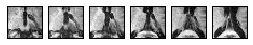

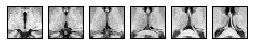

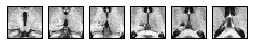

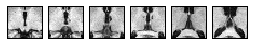

In [108]:
visualize_lesions('/home/despoB/kaihwang/Rest/Lesion_Masks/163_MNI_final_2x2x2.nii.gz', 'Data/S1.png')
visualize_lesions('/home/despoB/kaihwang/Rest/Lesion_Masks/128_MNI_final_2x2x2.nii.gz', 'Data/S2.png')
visualize_lesions('/home/despoB/kaihwang/Rest/Lesion_Masks/168_MNI_final_2x2x2.nii.gz', 'Data/S3.png')
visualize_lesions('/home/despoB/kaihwang/Rest/Lesion_Masks/176_MNI_final_2x2x2.nii.gz', 'Data/S4.png')
